In [1]:
!nvidia-smi

Tue Jan 19 16:24:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    40W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [2]:
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=0


'0'

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
#plt.style.use('dark_background')
import numpy as np
import torch
import cv2
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from  glob import glob
import os
#from PIL import Image
#from skimage import color
torch.manual_seed(0)
np.random.seed(0)

device(type='cuda')

In [5]:
#@title Parameters {display-mode: "form"}
#@markdown ---
batch_size = 64 #@param {type: "number"}
disc_iters = 5#@param {type: "number"}
gen_iters = 1#@param {type: "number"}
plot_iter = 50 #@param {type: "number"}
#@markdown ---
D_lr = 5e-5 #@param {type: "number"} #1e-4 er optimalt
G_lr = 5e-5 #@param {type: "number"} #1e-4 er optimalt

beta_1 = 0.9 #@param {type: "number"}
beta_2 = 0.999 #@param {type: "number"}
G_betas = D_betas = (beta_1, beta_2) #ONLY FOR ADAM
#@markdown ---
training_opt = "GP" #@param ["None","R1_reg", "GP", "R1_GP"]
R1_reg = 0.0 #@param {type: "slider", min: 0.0, max: 100.0, step: 0.1}
instance_noise_iter = 1000 #@param {type: "slider", min: 0.0, max: 20000, step: 100}
instance_smoothing = False #@param {type: "boolean"}
#@markdown ---
#Training options for reconstruction loss
recon_type = 'mse' #@param ["None", "huber", "mse"]
recon_lambda = 1.0 #@param [0.1,0.2,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.5,2.0,5.0,10.0,25.0,50.0,100.0,200.0] {type:"raw"}
#@markdown ---
downsample_type = "MaxPool" #@param ["Conv", "MaxPool"]

model_name = "MNIST-1mse-no-smooth-1000ins-noise"

In [6]:
hyper_params = {}
hyper_params['batch_size']=batch_size
hyper_params['disc_iters']=disc_iters
hyper_params['gen_iters']=gen_iters
hyper_params['plot_iter']=plot_iter
hyper_params['D_lr']=D_lr
hyper_params['G_lr']=G_lr
hyper_params['beta_1']=beta_1
hyper_params['beta_2']=beta_2
hyper_params['training_opt']=training_opt
hyper_params['R1_reg']=R1_reg
hyper_params['instance_noise_iter']=instance_noise_iter
hyper_params['instance_smoothing']=instance_smoothing
if recon_type in ['mse', 'huber']:
  hyper_params['recon_type']=recon_type
  hyper_params['recon_lambda']=recon_lambda
hyper_params['downsample_type']=downsample_type

In [ ]:
# For athletic field
# min_size = 256
# crop_size = 128
# if not os.path.exists(f'./{min_size}_sized_images.txt'):
#   with open(f'./{min_size}_sized_images.txt', 'w+') as f:
#     for p in tqdm(glob('data_256/a/athletic_field/outdoor/*.jpg')):
#       print(p, file=f)

# import multiprocessing
# resize_crop_transform = transforms.Compose([transforms.Resize(min_size),transforms.RandomCrop(crop_size)])
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, transform):
#       with open(f'./{min_size}_sized_images.txt', 'r') as f:
#         self.image_paths = f.read().splitlines()
#       self.transform = transform

#     def __len__(self):
#       return len(self.image_paths)

#     def __getitem__(self, idx):
#       im = cv2.imread(self.image_paths[idx])
#       #im_RGB = torch.tensor(cv2.cvtColor(im, cv2.COLOR_BGR2RGB) / 255.0, dtype=torch.float).permute(2,0,1)
#       im_Lab = torch.tensor(cv2.cvtColor(im, cv2.COLOR_BGR2Lab) / 255.0, dtype=torch.float).permute(2,0,1)
#       #im = self.transform(torch.cat([im_Lab, im_RGB],0))
#       im = self.transform(im_Lab)
#       return im

# dataset = CustomDataset(transform=resize_crop_transform)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count(), pin_memory=True)
# print(len(dataset))


In [7]:
import multiprocessing
class ColorMNIST(torch.utils.data.Dataset):
  def __init__(self, dataset):
    self.data = dataset.data
    self.targets = dataset.targets

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    pi = 3.1415927410125732
    image, label = self.data[idx], self.targets[idx]
    image = image / 255.0
    label = float(label) + torch.empty(1).uniform_(-0.5,0.5)
    a_const = torch.sin(2*pi*label/10.0)
    b_const = torch.cos(2*pi*label/10.0)
    sample = torch.stack([image,0.5*a_const/max(abs(a_const),abs(b_const))*image+0.5,0.5*b_const/max(abs(a_const),abs(b_const))*image+0.5])
    return sample
dataset = ColorMNIST(torchvision.datasets.MNIST('data', train=True, download=True))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
print(len(dataset))

60000


In [8]:
def get_samples(batch_size):
    idxs = np.random.randint(len(dataset), size=(batch_size,))
    return idxs, torch.stack([dataset[i] for i in idxs],0)

In [9]:
def Lab2RGB(im):
  if im.shape[0] == 3:
    im = im.permute(1,2,0)
  im = 255.0*im
  im = im.to(torch.uint8).numpy()
  return cv2.cvtColor(im, cv2.COLOR_Lab2RGB)

(-0.5, 241.5, 241.5, -0.5)

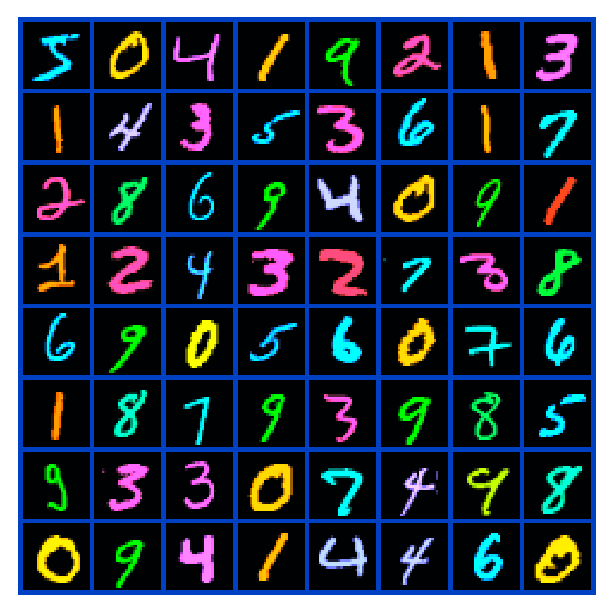

In [10]:
plt.figure(figsize=(4.25,4.25), dpi=180)
plt.imshow(Lab2RGB(torchvision.utils.make_grid([dataset[i] for i in range(8*8)],8).cpu()), interpolation='nearest')
plt.axis('off')

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

class ConvBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1, direction='in'):
    super(ConvBlock, self).__init__()
    if direction == 'out':
      self.BlockLayers = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
                                       nn.GELU(),
                                       *[l for _ in range(n_intermediate_layers) for l in [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),nn.GELU()]])
    else:
      self.BlockLayers = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                                       nn.GELU(),
                                       *[l for _ in range(n_intermediate_layers) for l in [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),nn.GELU()]])
  def forward(self, x):
    x = self.BlockLayers(x)
    return x

class EncoderBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1):
    super(EncoderBlock, self).__init__()
    self.EncoderBlock = ConvBlock(in_channels, out_channels, n_intermediate_layers, direction='in')
    self.DownSample = nn.MaxPool2d(2) if downsample_type == 'MaxPool' else nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1), nn.GELU())

  def forward(self, x):
    x = self.EncoderBlock(x)
    skip = x
    x = self.DownSample(x)
    return x, skip

class DecoderBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1):
    super(DecoderBlock, self).__init__()
    if upsample_type == 'PixelShuffle':
      self.UpSample = PixelShuffleUpsample(in_channels,2)#
    else:
      self.UpSample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
    self.DecoderBlock = ConvBlock(in_channels, out_channels, n_intermediate_layers, direction='out')

  def forward(self, x, skip):
    x = self.UpSample(x)
    x = self.DecoderBlock(x + skip)
    return x


In [12]:
#Unet Basic
class GeneratorUNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorUNet, self).__init__()
    #Encoder Mapping
    self.enc_block1 = EncoderBlock(1,256,1)
    self.enc_block2 = EncoderBlock(256,256,1)

    #Skip connection Instance Norms
    self.skip_IN1 = nn.InstanceNorm2d(256, affine=True)
    self.skip_IN2 = nn.InstanceNorm2d(256, affine=True)
    
    #Bottleneck
    self.bot_block1 = ConvBlock(256,512,1, direction='in')
    self.bot_block2 = ConvBlock(512,256,1, direction='out')

    #Decoder
    self.dec_block1 = DecoderBlock(256,256,1)
    self.dec_block2 = DecoderBlock(256,256,1)
    
    #Out
    self.out_conv = nn.Conv2d(256, 2, kernel_size=1, stride=1, padding=0, bias=True)


  def forward(self, gray):
    x = gray
    #x = torch.cat([x, torch.randn(x.size(0), 2, x.size(2), x.size(3), device=x.device)], 1)
    x, skip1 = self.enc_block1(x)
    x, skip2 = self.enc_block2(x)
    
    #Bottleneck 
    x = self.bot_block1(x)

    #Skip AdaINs
    skip1 = self.skip_IN1(skip1)
    skip2 = self.skip_IN2(skip2)
    
    x = self.bot_block2(x)

    #Decoder 
    x = self.dec_block1(x, skip2)
    x = self.dec_block2(x, skip1)

    #Out
    out = torch.sigmoid(self.out_conv(x))    
    out = torch.cat([gray, out],1)
    return out


GNet = GeneratorUNet().to(device)
GNet.apply(weights_init)
print(GNet)
print("Generator trainable parameters:", sum(p.numel() for p in GNet.parameters() if p.requires_grad))

GeneratorUNet(
  (enc_block1): EncoderBlock(
    (EncoderBlock): ConvBlock(
      (BlockLayers): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GELU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): GELU()
      )
    )
    (DownSample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block2): EncoderBlock(
    (EncoderBlock): ConvBlock(
      (BlockLayers): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GELU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): GELU()
      )
    )
    (DownSample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (skip_IN1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (skip_IN2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [13]:
#Unet Basic
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    #resnet = models.resnet34()
    #self.resnet = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4, resnet.avgpool)


    # #Encoder
    self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
    self.enc_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.enc_down1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

    self.enc_conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.enc_conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.enc_down2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

    self.enc_conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    self.enc_conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    
    #Out
    self.out_conv = nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    x = res = F.gelu(self.enc_conv1(x))# 
    x = res + F.gelu(self.enc_conv2(x))# 
    x = res = F.gelu(self.enc_down1(x))
    
    x = res = res + F.gelu(self.enc_conv3(x))#
    x = res = res + F.gelu(self.enc_conv4(x))#
    x = res = F.gelu(self.enc_down2(x))

    x = res = res + F.gelu(self.enc_conv5(x))#
    x = res + F.gelu(self.enc_conv6(x))#
    
    x = F.gelu(self.out_conv(x))
    return x

DNet = DiscriminatorNet().to(device)
DNet.apply(weights_init)
print(DNet)
print("Discriminator trainable parameters:", sum(p.numel() for p in DNet.parameters() if p.requires_grad))

DiscriminatorNet(
  (enc_conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_down1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_down2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out_conv): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
)
Discriminator trainable parameters: 8051584


In [14]:
def Lab2RGB(im):
  if im.shape[0] == 3:
    im = im.permute(1,2,0)
  im = 255.0*im
  im = im.to(torch.uint8).numpy()
  return cv2.cvtColor(im, cv2.COLOR_Lab2RGB)

def smooth(scalars, weight):
	last = scalars[0]
	smoothed = list()
	for point in scalars:
		smoothed_val = last * weight + (1 - weight) * point
		smoothed.append(smoothed_val)
		last = smoothed_val
	return smoothed

def anneal(val, target):
  return max((target-val)/target,0)

In [15]:
from torch.cuda.amp.autocast_mode import autocast
#from torch.cuda.amp import GradScaler

from collections import defaultdict

G_optimizer = torch.optim.Adam(GNet.parameters(), lr=G_lr, betas=G_betas)
D_optimizer = torch.optim.Adam(DNet.parameters(), lr=D_lr, betas=D_betas)

losss_print = defaultdict(lambda: [])
print_to_legend = {
'Div.':r'Div.',
'G.i+1':r'$D(G_{i+1}(z|y))$',
'D.':r'$D(x)$',
'G.i':r'$D(G_{i}(z|y))$'
}

mse_loss_fn = nn.MSELoss()
huber_loss_fn = nn.SmoothL1Loss(beta=0.5)
iteration = -1
#Linear annealing

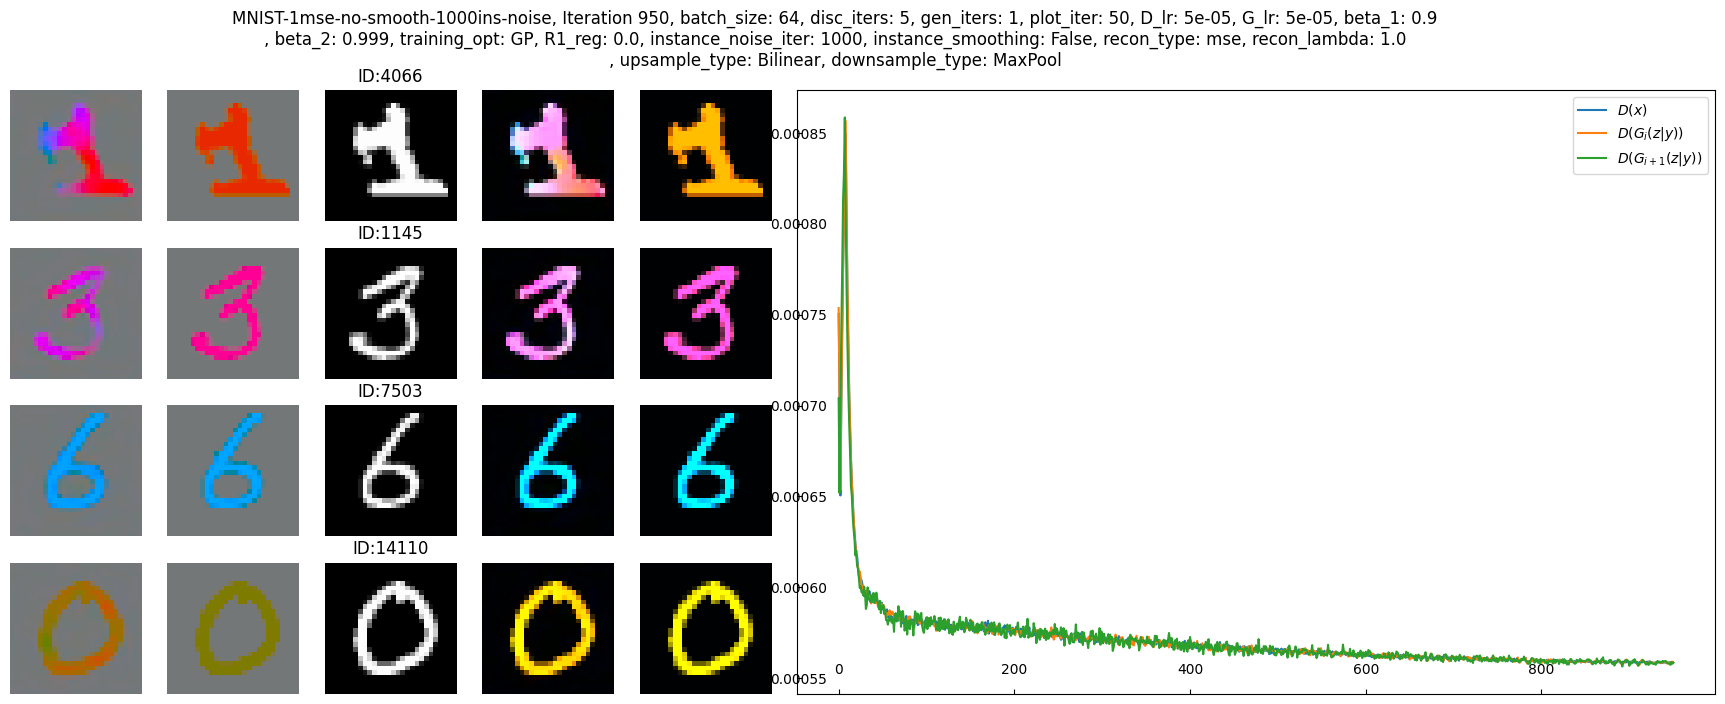

100%|███████████████████████████████████████████████████████████████████████████████████| 384000/384000 [12:19<00:00, 519.37img/s, Iteration 999, I.N.A.: 0.001, D.: 0.0006, G.i: 0.0006, G.i+1: 0.0006]


In [16]:

with tqdm(range(1000),unit_scale=(gen_iters+disc_iters)*batch_size, unit='img', ncols=200) as tqdm_bar:#, autocast():#
    for iteration in tqdm_bar:
        GNet.train()
        DNet.train()
        #https://arxiv.org/pdf/1610.04490.pdf & https://arxiv.org/pdf/1701.04862.pdf
        instance_noise_annealing = anneal(iteration,instance_noise_iter)
        DNet.zero_grad()
        #---start disc loop---
        disc_real_avg = 0.0
        disc_fake_avg = 0.0
        for _ in range(disc_iters):
            idxs, real = get_samples(batch_size)
            real = real.to(device).requires_grad_(True)
            gray = real[:,:1]

            fake = GNet(gray)

            #Training Discriminator

            if instance_smoothing:
                alpha = 0.5*instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
                real_input = (1-alpha) * real +  alpha * fake.detach()
            else:
                real_input = real
        
            real_noise = (instance_noise_annealing*np.sqrt(2))*torch.randn_like(real, device=device)

            disc_real = DNet(real_input+real_noise)

            Dreal_loss = F.softplus(-disc_real).mean()
      
            if instance_smoothing:
                alpha = 0.5*instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
                fake_input = alpha * real + (1-alpha) * fake.detach()
            else:
                fake_input = fake.detach()
      
            fake_noise = (instance_noise_annealing*np.sqrt(2))*torch.randn_like(real, device=device)

            disc_fake = DNet(fake_input + fake_noise)

            Dfake_loss = F.softplus(disc_fake).mean()

            #https://arxiv.org/pdf/1801.04406.pdf - R1 Reguilarization
            grad_penalty = 0.0
            if training_opt in ['R1_reg', 'R1_GP']:
                real_grad = torch.autograd.grad(outputs=disc_real.sum(), inputs=real, create_graph=True, only_inputs=True)[0]
                grad_penalty += (R1_reg / 2)*real_grad.view(real_grad.size(0), -1).square().sum(-1).mean()
      
            #https://arxiv.org/pdf/1704.00028.pdf afsnit 4 - gradient penalty
            if training_opt in ['GP', 'R1_GP']:
                alpha = torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
                interp = alpha * real + (1-alpha) * fake.detach()
                disc_interp = DNet(interp)
                interp_grad = torch.autograd.grad(outputs=disc_interp.sum(), inputs=interp, create_graph=True, only_inputs=True)[0]
                grad_penalty += 10.0*F.relu(interp_grad.view(interp_grad.size(0), -1).norm(2, dim=1).subtract(1.0)).square().sum(-1).mean()

            D_loss = Dreal_loss + Dfake_loss + grad_penalty
            D_loss.backward()
            
            disc_real_avg += disc_real.mean().item()
            disc_fake_avg += disc_fake.mean().item()
        #---end disc loop---
        D_optimizer.step()
        losss_print['D.'].append(disc_real_avg/disc_iters)
        losss_print['G.i'].append(disc_fake_avg/disc_iters)

        #Training Generator
        GNet.zero_grad()
        #---Start generator loop---
        disc_gen_avg = 0.0
        for _ in range(gen_iters):
            idxs, real = get_samples(batch_size)
            real = real.to(device).requires_grad_(True)
            gray = real[:,:1]

            fake = GNet(gray)

            if instance_smoothing:
                alpha = 0.5*instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
                gen_input = alpha * real.detach() + (1-alpha) * fake
            else:
                gen_input = fake

            gen_noise = (instance_noise_annealing*np.sqrt(2))*torch.randn_like(real, device=device)


            disc_gen = DNet(gen_input+gen_noise)
            
            G_loss = F.softplus(-disc_gen).mean()#criterion(output, torch.full_like(output, 1.0, dtype=torch.float, device=device))
            
            recon_loss = 0.0
            if recon_type == 'mse':
                recon_loss = mse_loss_fn(fake[:,1:],real[:,1:])
            elif recon_type == 'huber':
                recon_loss = huber_loss_fn(fake[:,1:],real[:,1:])
            (G_loss+recon_lambda*recon_loss).backward()
            
            disc_gen_avg += disc_gen.mean().item()
        #---end generator loop---
        G_optimizer.step()
        losss_print['G.i+1'].append(disc_gen_avg/gen_iters)
      
        with torch.no_grad():
            tqdm_bar.set_postfix_str(f"Iteration {iteration}, I.N.A.: {instance_noise_annealing:.3f}, "
                         +", ".join([f"{ns}: {ls[-1]:.4f}" for ns, ls in losss_print.items()]))
            if iteration % plot_iter == 0:
                clear_output(wait=True)
                #evaluate
                fig, axs = plt.subplots(4,11,figsize=(22,8), dpi=100)
                gs = axs[0, 5].get_gridspec()
                for axs_y in axs[:, 5:]:
                    for ax in axs_y:
                        ax.remove()
                fig.suptitle(f"{model_name}, Iteration {iteration}, "+", ".join([f"{k}: {v}"+("\n" if (i+1) % 7 == 0 else "") for i,(k, v) in enumerate(hyper_params.items())]))
                axbig = fig.add_subplot(gs[:, 5:])
                axbig.tick_params(direction='in', pad=-22)
                legend = []
                for ns,ls in losss_print.items():
                    axbig.plot(ls)
                    legend.append(print_to_legend[ns])
                axbig.legend(legend)
                im_pred_ = fake[:,-3:].cpu().detach()
                im_gray_ = gray.cpu().detach()
                im_true_ = real[:,-3:].cpu().detach()
                for i in range(4):
                    axs[i][0].imshow(Lab2RGB(im_pred_[i].permute(1,2,0).float()*torch.tensor([0.0,1.0,1.0]).view(1,1,3)+torch.tensor([0.5,0.0,0.0]).view(1,1,3)), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
                    axs[i][1].imshow(Lab2RGB(im_true_[i].permute(1,2,0).float()*torch.tensor([0.0,1.0,1.0]).view(1,1,3)+torch.tensor([0.5,0.0,0.0]).view(1,1,3)), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
                    axs[i][2].imshow(im_gray_[i].permute(1,2,0).squeeze().float(), cmap='gray', interpolation='nearest', aspect='equal', vmin=0, vmax=1)
                    axs[i][3].imshow(Lab2RGB(im_pred_[i].permute(1,2,0).float()), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
                    axs[i][4].imshow(Lab2RGB(im_true_[i].permute(1,2,0).float()), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
                    axs[i][0].set_axis_off()
                    axs[i][1].set_axis_off()
                    axs[i][2].set_axis_off()
                    axs[i][3].set_axis_off()
                    axs[i][4].set_axis_off()
                    axs[i][2].set_title(f"ID:{idxs[i]}")
                #fig.savefig(f"I_{iteration}_results.png", dpi=180)
                plt.show()
                #torch.save({'gnet':GNet.state_dict(), 'dnet':DNet.state_dict()}, 'save_athletic_field.h')

In [17]:
torch.save({'gnet':GNet.state_dict(), 'dnet':DNet.state_dict()}, f'{model_name}.h')

In [19]:
#s_dict = torch.load(f"{model_name}.h")

In [20]:
#s_dict = torch.load(f"{model_name}.h")
#GNet.load_state_dict(s_dict['gnet'])

In [21]:
#for i in range(20):
#    real_sample = get_samples(512)
#    for i_r, r in enumerate(real_sample):
#        im_rgb = Lab2RGB(r)
#        cv2.imwrite(f"MNIST_real/{i*512+i_r}.jpg", im_rgb)

In [22]:
%%bash -s "$model_name"
mkdir "$1"

In [23]:
real_paths = list(glob("MNIST_real/*.jpg"))
with torch.no_grad():
    for i in range(20):
        im_paths = real_paths[i*512:(i+1)*512]
        gray = torch.stack([torch.tensor(cv2.imread(f,cv2.IMREAD_GRAYSCALE), device=device).unsqueeze(0)/255.0 for f in im_paths])
        fake_sample = GNet(gray)
        for i_f, f in enumerate(fake_sample):
            im_rgb = Lab2RGB(f.cpu())
            cv2.imwrite(f"{model_name}/{os.path.basename(im_paths[i_f])}", im_rgb)

In [24]:
%%bash -s "$model_name"
python3 -m pytorch_fid --device cuda:0 "MNIST_real" "$1"

FID:  18.00709142107081


100%|##########| 205/205 [00:13<00:00, 15.37it/s]


In [25]:
model_name

'MNIST-1mse-no-smooth-1000ins-noise'